In [2]:
import pyspark


In [3]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("TestPySpark").getOrCreate()

# Check version
print("Spark version:", spark.version)


Spark version: 3.5.0


In [4]:
data = [("Alice", 25), ("Bob", 30), ("Charlie", 35)]
columns = ["Name", "Age"]

df = spark.createDataFrame(data, columns)

df.show()


+-------+---+
|   Name|Age|
+-------+---+
|  Alice| 25|
|    Bob| 30|
|Charlie| 35|
+-------+---+



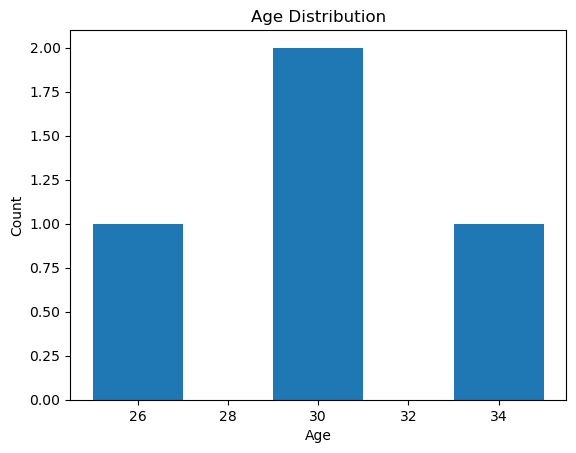

In [5]:
import matplotlib.pyplot as plt

# Example data
data = [("Alice", 25), ("Bob", 30), ("Charlie", 35), ("David", 30)]
columns = ["Name", "Age"]

df = spark.createDataFrame(data, columns)

# Convert to Pandas
pdf = df.toPandas()

# Plot histogram of ages
plt.hist(pdf["Age"], bins=5)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.show()


In [10]:
from pyspark.sql import SparkSession

# 1. Initialize SparkSession and SparkContext
spark = SparkSession.builder \
    .appName("RDD_Demo") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

# 2. Create an RDD from a Python list
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rdd = sc.parallelize(data)
print("Original RDD elements:", rdd.collect())

# 3. RDD Transformations

# Map: Apply a function to each element
squared_rdd = rdd.map(lambda x: x * x)
print("Squared RDD elements:", squared_rdd.collect())

# Filter: Select elements based on a condition
even_rdd = rdd.filter(lambda x: x % 2 == 0)
print("Even RDD elements:", even_rdd.collect())

# FlatMap: Transform each element into zero or more new elements
words_rdd = sc.parallelize(["hello spark", "rdd demo"])
flat_mapped_rdd = words_rdd.flatMap(lambda line: line.split(" "))
print("FlatMapped RDD elements:", flat_mapped_rdd.collect())

# 4. RDD Actions

# Reduce: Aggregate elements using a commutative and associative function
sum_of_elements = rdd.reduce(lambda a, b: a + b)
print("Sum of elements in original RDD:", sum_of_elements)

# Count: Return the number of elements in the RDD
count_elements = rdd.count()
print("Number of elements in original RDD:", count_elements)

# First: Return the first element of the RDD
first_element = rdd.first()
print("First element of original RDD:", first_element)

# Take: Return the first 'n' elements of the RDD
take_elements = rdd.take(3)
print("First 3 elements of original RDD:", take_elements)

# Collect: Return all elements of the RDD as a list to the driver program
all_elements = rdd.collect()
print("All elements collected:", all_elements)

# 5. Stop SparkSession
spark.stop()

Original RDD elements: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Squared RDD elements: [1, 4, 9, 16, 25, 36, 49, 64, 81, 100]
Even RDD elements: [2, 4, 6, 8, 10]
FlatMapped RDD elements: ['hello', 'spark', 'rdd', 'demo']
Sum of elements in original RDD: 55
Number of elements in original RDD: 10
First element of original RDD: 1
First 3 elements of original RDD: [1, 2, 3]
All elements collected: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [11]:
from pyspark.sql import SparkSession

# 1. Initialize SparkSession and SparkContext
spark = SparkSession.builder \
    .appName("RDD_Partitions_Demo") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

# 2. Create an RDD from a Python list (Spark defaults to numSlices = min(128, data size) in local mode)
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rdd = sc.parallelize(data)  # Default partitions: often 2–4 in local[*] mode
print("Number of partitions in original RDD:", rdd.getNumPartitions())

# Explicitly create with a specific number of partitions
rdd_fixed = sc.parallelize(data, numSlices=3)
print("Number of partitions in fixed RDD:", rdd_fixed.getNumPartitions())

# 3. Transformations don't change partition count by default (e.g., map/filter)
squared_rdd = rdd.map(lambda x: x * x)
print("Number of partitions after map:", squared_rdd.getNumPartitions())  # Same as original

even_rdd = rdd.filter(lambda x: x % 2 == 0)
print("Number of partitions after filter:", even_rdd.getNumPartitions())  # Same as original

# But some transformations can repartition (e.g., repartition() or operations like join)
repartitioned_rdd = rdd.repartition(5)
print("Number of partitions after repartition(5):", repartitioned_rdd.getNumPartitions())

# 4. Other useful partition-related methods
print("Partitions per core (rough estimate):", rdd.getNumPartitions() / sc.defaultParallelism)
print("Partition sizes (in bytes, approximate):", rdd.glom().map(len).collect())  # List of element counts per partition

# 5. Stop SparkSession
spark.stop()

Number of partitions in original RDD: 12
Number of partitions in fixed RDD: 3
Number of partitions after map: 12
Number of partitions after filter: 12
Number of partitions after repartition(5): 5
Partitions per core (rough estimate): 1.0
Partition sizes (in bytes, approximate): [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


In [12]:
from pyspark.sql import SparkSession

# 1. Initialize SparkSession and SparkContext
spark = SparkSession.builder \
    .appName("RDD_Partitions_Elements_Demo") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

# 2. Create an RDD with explicit partitions for clarity (e.g., 3 partitions)
data = list(range(1, 11))  # [1, 2, ..., 10]
rdd = sc.parallelize(data, numSlices=3)  # Forces 3 partitions
print("Number of partitions:", rdd.getNumPartitions())

# 3. Glom to get elements per partition, then collect
partition_elements = rdd.glom().collect()
print("Elements in each partition:")
for i, partition in enumerate(partition_elements):
    print(f"  Partition {i}: {partition}")

# 4. After a transformation (e.g., filter), partitions remain the same unless repartitioned
even_rdd = rdd.filter(lambda x: x % 2 == 0)
even_partitions = even_rdd.glom().collect()
print("\nElements in each partition after filter (evens only):")
for i, partition in enumerate(even_partitions):
    print(f"  Partition {i}: {partition}")

# Bonus: Partition sizes (number of elements per partition)
partition_sizes = rdd.glom().map(len).collect()
print("\nNumber of elements per partition:", partition_sizes)

# 5. Stop SparkSession
spark.stop()

Number of partitions: 3
Elements in each partition:
  Partition 0: [1, 2, 3]
  Partition 1: [4, 5, 6]
  Partition 2: [7, 8, 9, 10]

Elements in each partition after filter (evens only):
  Partition 0: [2]
  Partition 1: [4, 6]
  Partition 2: [8, 10]

Number of elements per partition: [3, 3, 4]
